# Team15_Project1

This is the deliverable ipynb file for BIOINF 575 Bioinformatics project assignment.

Team 15 members: John Larson, Henry Li, Ziyan Xu

Project topic: Drug Annotation of 23andme Report

## Input Data

`23andme_v5_hg19_ref.txt.gz` - retrieved at [23andme2vcf](https://github.com/arrogantrobot/23andme2vcf)

`var_drug_ann.tsv` - retrieved at [ClinPGx](https://www.clinpgx.org/downloads) (previously PharmGKB) as variantAnnotations.zip

the file was extracted and brought to the repository root directory for ease of access

## Imports, Functions, and Translations

In [1]:
import gzip

In [2]:
def getfp(filename):
	"""Returns a file pointer for reading based on file name"""
	if filename.endswith('.gz'):
		return gzip.open(filename, 'rt', encoding='utf-8')
	else:
		return open(filename, 'r', encoding='utf-8')


def is_valid_allele(allele_entry):
	"""Checks if allele entry is valid"""
	allele_entry = allele_entry.strip().upper()
	if not allele_entry: # empty string
		return False
	if any(x in allele_entry for x in ["A", "C", "G", "T", "DEL", "/", "+"]):
		return True
	return False


def to_tsv(data_dict, filename, sep="\t", columns=None):
	"""Writes a dictionary of dictionaries to a TSV file."""
	with open(filename, 'w', encoding='utf-8') as fp:
		# write header
		if columns:
			fp.write(sep.join(columns) + "\n")
		else:
			# no header, write all keys from the dictionary values
			fp.write(sep.join(next(iter(data_dict.values())).keys()) + "\n")

		# write rows
		for entry in data_dict.values():
			if columns:
				row = [entry.get(col, "") for col in columns]
			else:
				row = list(entry.values())
			fp.write(sep.join(row) + "\n")

In [3]:
char_trans_table = str.maketrans({
	'"': '',        # remove quotes
	' ': ' ',       # U+00a0 - regular space
	' ': ' ',       # U+2009 - regular space
	' ': ' ',       # U+202F - regular space
	' ': ' ',       # U+2003 - regular space
	' ': ' ',       # U+2005 - regular space
	'–': '-',       # U+2013 - regular hyphen
})

## Task 1

**Map/merge** the 23andme file and the variant-drug annotation file based on dbSNP_ID (aka rsID).

The merged result should have the following columns:

```
dbSNP_ID, GENE_SYMBOL, DRUG_NAME, PMID, PHENOTYPE_CATEGORY, SIGNIFICANCE, NOTES, SENTENCE, ALLELE_PharmGKB (variant alleles in annotation), ALLELE_23andme (variant alleles in 23andme file)
```

In [4]:
# read PharmGKB variant drug annotation file
ann_entries = {}  # entryID -> {entry_info dict}

with getfp('var_drug_ann.tsv') as fp:
	# get wanted column names
	oldcols = fp.readline().strip().split('\t')[1:10]
	oldcols = [i.upper() for i in oldcols]
	cols = []

	# new column names
	for col in oldcols:
		if col == 'VARIANT/HAPLOTYPES':
			col = 'dbSNP_ID'
		elif col == 'GENE':
			col = 'GENE_SYMBOL'
		elif col == 'DRUG(S)':
			col = 'DRUG_NAME'
		elif col == 'ALLELES':
			col = 'ALLELE_PharmGKB'
		if ' ' in col:
			col = col.replace(' ', '_')
		cols.append(col)

	# parse entries
	for line in fp:
		original_fields = line.strip().split('\t')

		# remove bad characters and unwanted quotes in fields
		fields = [
			i.translate(char_trans_table) for i in original_fields
		]

		# check second column for rsID presence
		if "rs" not in fields[1]:
			continue  # skip non-rsID entries

		# check allele validity
		if not is_valid_allele(fields[9]):
			continue  # skip invalid allele entries

		entryID = fields[0]

		entry_info = {}
		for i, col in enumerate(cols):
			entry_info[col] = fields[i + 1]  # offset by 1

		ann_entries[entryID] = entry_info  # entryID -> {entry_info dict}

print(len(ann_entries))

9830


In [6]:
# read 23andMe v5 file
snp_entries = {} # rsID -> allele

with getfp('23andMe_v5_hg19_ref.txt.gz') as fp:
	for line in fp:
		fields = line.strip().split('\t')
		rsID = fields[2]

		# check for rsID presence
		if "rs" not in rsID:
			continue

		snp_entries[rsID] = fields[3] # rsID -> allele

print(len(snp_entries))

620634


In [7]:
# merge results by rsID
merged_entries = {} # entryID -> {entry_info dict + ALLELE_23andme: allele}

for entryID, entry_info in ann_entries.items():
	dbSNP_ID = entry_info.get('dbSNP_ID')
	if dbSNP_ID in snp_entries:
		# entryID -> {entry_info dict + ALLELE_23andme: allele}
		# entryID -> {merged_info dict}
		merged_entries[entryID] = {**entry_info, 'ALLELE_23andme': snp_entries[dbSNP_ID]}

print(len(merged_entries))

6111


## Task 2

**Filter** the output so that it only contains significant associations (**SIGNIFICANCE** is **yes**) for variants that affect the drug efficacy (**PHENOTYPE_CATEGORY** is **efficacy**).

In [8]:
# filter for SIGNIFICANCE == 'yes' and PHENOTYPE_CATEGORY is 'efficacy'
filtered_entries = {} # entryID -> {filtered_info dict}
for entryID, merged_info in merged_entries.items():
	if merged_info.get('SIGNIFICANCE').lower() == 'yes' and merged_info.get('PHENOTYPE_CATEGORY').lower() == 'efficacy':
		filtered_entries[entryID] = merged_info

print(len(filtered_entries))

1434


## Task 3

**Save** the output of the filtering step in a tab-separated file (**23andme_PharmGKB_map.tsv**) with the following columns:

```
dbSNP_ID, GENE_SYMBOL, DRUG_NAME, NOTES, SENTENCE, ALLELE_PharmGKB, ALLELE_23andme
```

In [9]:
# save the output in tsv file
output_cols = [
	"dbSNP_ID", "GENE_SYMBOL", "DRUG_NAME",
	"NOTES", "SENTENCE", "ALLELE_PharmGKB", "ALLELE_23andme"
]

to_tsv(
	filtered_entries,
	"23andme_PharmGKB_map.tsv",
	sep="\t",
	columns=output_cols
)

print("File saved as 23andme_PharmGKB_map.tsv")

File saved as 23andme_PharmGKB_map.tsv


## Task 4

**Create** a tab separated file (**23andme_PharmGKB_summary.tsv**) with summarized data with the following columns:

```
GENE_SYMBOL, DRUG_NAME, dbSNP_IDs (list of IDs separated by ";")
```

In [10]:
import pandas as pd

# Load the merged TSV from Task 1
df = pd.read_csv("23andme_PharmGKB_map.tsv", sep="\t")

# Keep only the required columns
df_subset = df[["GENE_SYMBOL", "DRUG_NAME", "dbSNP_ID"]].dropna()

# Step 1: Create an empty list to store summarized rows
summary_rows = []

# Step 2: Group the dataframe by gene and drug
for (gene, drug), group in df_subset.groupby(["GENE_SYMBOL", "DRUG_NAME"]):
    # Get all unique dbSNP_IDs for this gene–drug pair
    snps = sorted(set(group["dbSNP_ID"]))
    
    # Join them into a single string
    snp_list = ";".join(snps)
    
    # Append a dictionary (one row of output)
    summary_rows.append({
        "GENE_SYMBOL": gene,
        "DRUG_NAME": drug,
        "dbSNP_IDs": snp_list
    })

# Step 3: Convert that list of dicts back into a DataFrame
summary_df = pd.DataFrame(summary_rows)


# Save summarized output to new TSV
summary_df.to_csv("23andme_PharmGKB_summary.tsv", sep="\t", index=False)

print("Summary file created: 23andme_PharmGKB_summary.tsv")
print(summary_df.head())


Summary file created: 23andme_PharmGKB_summary.tsv
  GENE_SYMBOL                                DRUG_NAME            dbSNP_IDs
0       ABCA1  atorvastatin, rosuvastatin, simvastatin            rs2230806
1       ABCA1                              fenofibrate  rs2230806;rs2230808
2       ABCB1                          antidepressants            rs1128503
3       ABCB1                           antipsychotics            rs1128503
4       ABCB1                            carbamazepine            rs1128503


## Task 5

**Plot** the distribution (histogram) of the number of drugs associated with a gene, and the number of SNPs for a gene.

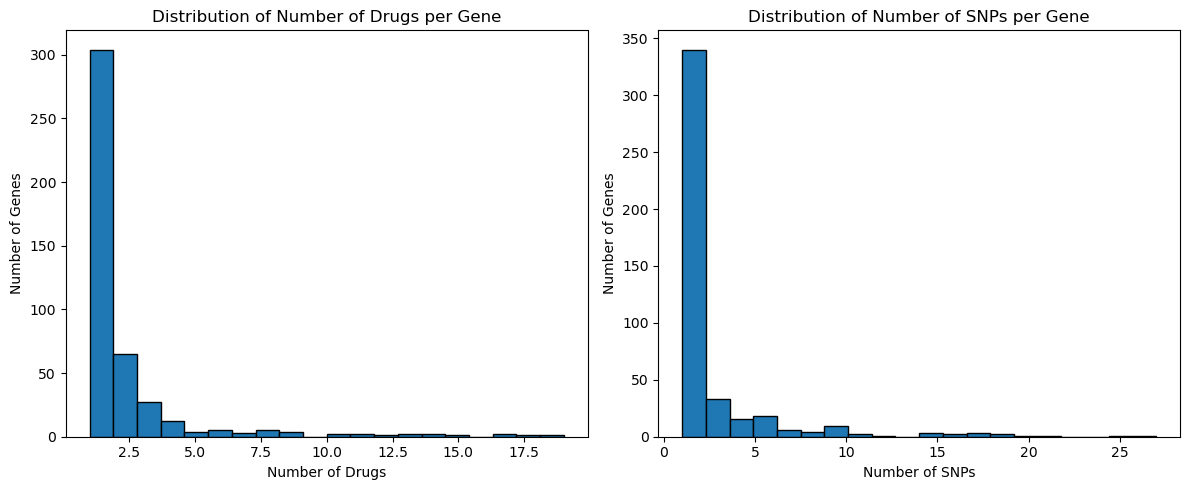

In [11]:

import matplotlib.pyplot as plt
# 1) Number of drugs per gene
drugs_per_gene = (
    summary_df.groupby("GENE_SYMBOL")["DRUG_NAME"]
    .nunique()
    .reset_index(name="num_drugs")
)

# 2) Number of SNPs per gene
#    First, count SNPs in each gene–drug row, then sum across a gene
snp_counts = (
    summary_df.assign(num_snps=summary_df["dbSNP_IDs"].apply(lambda x: len(str(x).split(";"))))
    .groupby("GENE_SYMBOL")["num_snps"]
    .sum()
    .reset_index()
)

# Plot
plt.figure(figsize=(12, 5))

# Plot 1 - number of drugs associated with a gene
plt.subplot(1, 2, 1)
plt.hist(drugs_per_gene["num_drugs"], bins=20, edgecolor="black")
plt.title("Distribution of Number of Drugs per Gene")
plt.xlabel("Number of Drugs")
plt.ylabel("Number of Genes")

# Plot 2 - number of SNPs associated with a gene
plt.subplot(1, 2, 2)
plt.hist(snp_counts["num_snps"], bins=20, edgecolor="black")
plt.title("Distribution of Number of SNPs per Gene")
plt.xlabel("Number of SNPs")
plt.ylabel("Number of Genes")

plt.tight_layout()
plt.show()


## Task 6

As a team decide on a new feature for each of the team members to implement. These new features should be included in the solution and should answer a relevant biological question using the data available for the project. New data can be used for the implementation of these new features.

<span style="font-size:26px; font-weight:bold;">
Identifying Drug Pairs with Shared SNPs (by John)
</span>

In this extension, I identified drug pairs that share the same SNPs in the filtered PharmGKB–23andMe dataset, 
focusing only on overlapping single drugs.  
This analysis shows where different medications are linked through common SNPs.

For example, antipsychotics and antidepressants share SNPs such as **rs1128503** in *ABCB1* and **rs6265** in *BDNF*,  
which affect drug transport across the blood–brain barrier and neuronal signaling.

This demonstrates how shared SNPs can reveal biological overlap between drug classes with different clinical uses,  
potentially helping explain similarities in treatment response.


In [15]:
# John's New Feature
from itertools import combinations
import pandas as pd

# Read the same file you used earlier (Task 4)
df = pd.read_csv("23andme_PharmGKB_map.tsv", sep="\t")

# Remove combination therapy entries (anything with multiple drugs listed)
df_clean = df[~df["DRUG_NAME"].str.contains(",", regex=False)]

df_clean2 = df_clean[
    ~df_clean["DRUG_NAME"].str.contains(
        "antipsychotic|antidepressant|inhibitor", case=False
    )
]

# Group cleaned drugs by SNP
snp_to_drugs = (
    df_clean.groupby("dbSNP_ID")["DRUG_NAME"]
    .apply(lambda x: sorted(set(x)))
    .reset_index(name="DRUG_LIST")
)

pairs = []
for _, row in snp_to_drugs.iterrows():
    drugs = row["DRUG_LIST"]
    if len(drugs) > 1:
        for d1, d2 in combinations(drugs, 2):
            pairs.append((d1, d2))

drug_pair_df = (
    pd.DataFrame(pairs, columns=["DRUG_1", "DRUG_2"])
    .value_counts()
    .reset_index(name="shared_snp_count")
    .sort_values(by="shared_snp_count", ascending=False)
)

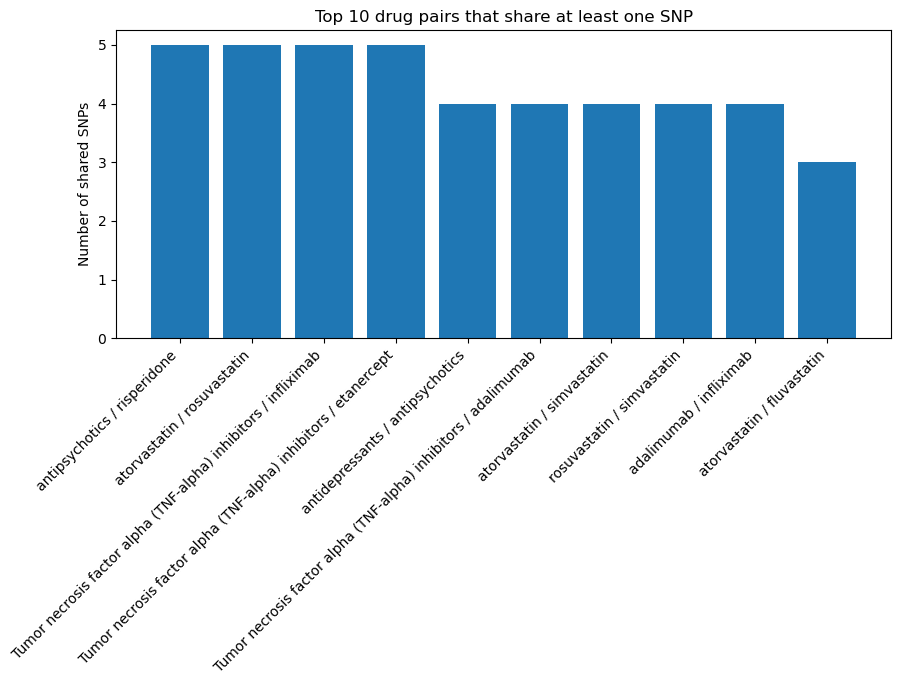

In [16]:
import matplotlib.pyplot as plt

top_pairs = drug_pair_df.head(10)

plt.figure(figsize=(10, 4))
plt.bar(
    [f"{r.DRUG_1} / {r.DRUG_2}" for _, r in top_pairs.iterrows()],
    top_pairs["shared_snp_count"]
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of shared SNPs")
plt.title("Top 10 drug pairs that share at least one SNP")
plt.show()


In [17]:
# Get SNPs shared by atorvastatin and rosuvastatin
pair = ("atorvastatin", "rosuvastatin")

shared = df[
    df["DRUG_NAME"].isin(pair)
].groupby("dbSNP_ID")["DRUG_NAME"].nunique()

shared_snps = shared[shared == 2].index.tolist()
print(shared_snps)


['rs4149056', 'rs662799', 'rs708272', 'rs7412', 'rs776746']


In [18]:
shared_snp_table = []

# Loop over the top 10 drug pairs
for _, row in drug_pair_df.head(10).iterrows():
    pair = (row["DRUG_1"], row["DRUG_2"])
    
    # Find SNPs where both drugs in the pair are annotated for that SNP
    shared = (
        df_clean[df_clean["DRUG_NAME"].isin(pair)]
        .groupby("dbSNP_ID")["DRUG_NAME"]
        .nunique()
    )
    
    shared_snps = shared[shared == 2].index.tolist()
    
    shared_snp_table.append({
        "DRUG_1": pair[0],
        "DRUG_2": pair[1],
        "SHARED_SNPS": ";".join(shared_snps)
    })

shared_snp_df = pd.DataFrame(shared_snp_table)
shared_snp_df


,DRUG_1,DRUG_2,SHARED_SNPS
0,antipsychotics,risperidone,rs1128503;rs2299214;rs4586;rs4795893;rs6280
1,atorvastatin,rosuvastatin,rs4149056;rs662799;rs708272;rs7412;rs776746
2,Tumor necrosis factor alpha (TNF-alpha) inhibi...,infliximab,rs1061622;rs1800629;rs1801274;rs361525;rs3794271
3,Tumor necrosis factor alpha (TNF-alpha) inhibi...,etanercept,rs1061622;rs1799724;rs1800629;rs2546890;rs3794271
4,antidepressants,antipsychotics,rs10501087;rs1128503;rs6265;rs7997012
5,Tumor necrosis factor alpha (TNF-alpha) inhibi...,adalimumab,rs1799724;rs1800629;rs1801274;rs361525
6,atorvastatin,simvastatin,rs2306283;rs4149056;rs662799;rs717620
7,rosuvastatin,simvastatin,rs12487736;rs4149056;rs5882;rs662799
8,adalimumab,infliximab,rs1800629;rs1801274;rs361525;rs763780
9,atorvastatin,fluvastatin,rs4149056;rs429358;rs7412


In [13]:
# Henry's New Feature

### Quantifying Risk Allele Concordance (by Ziyan)
A given SNP (dbSNP_ID) is located within a specific gene (GENE), and that gene may influence the response to one or more drugs (DRUG_NAME). PharmGKB provides the risk-associated genotypes for each SNP (ALLELE_PharmGKB). If the user’s allele (ALLELE_23andme) appears within any of these risk genotypes, it suggests a potential pharmacogenomic variant that may affect drug response. We further quantify the degree of concordance between the user’s allele and the PharmGKB risk genotypes using the MATCH_COUNT metric.

In [14]:
# Ziyan's New Feature

import pandas as pd

# Load merged data
df = pd.read_csv("23andme_PharmGKB_map.tsv", sep="\t")

# Convert PharmGKB allele string
def parse_risk_genotypes(pharmgkb_allele):
    if pd.isna(pharmgkb_allele):
        return []
    allele_str = str(pharmgkb_allele).upper().strip()
    return [g.strip() for g in allele_str.split("+")]

# match function
def count_risk_matches(risk_genotypes, user_allele):
    """
    Count how many risk genotypes the user matches.
    """
    if pd.isna(user_allele):
        return 0
    
    user_allele = str(user_allele).upper().strip()
    count = 0
    for g in risk_genotypes:
        # single-letter risk
        if len(g) == 1 and g == user_allele:
            count += 1
        # multi-letter risk genotype
        elif len(g) > 1 and user_allele in g:
            count += 1
    return count

# Parse risk genotypes
df["RISK_GENOTYPES"] = df["ALLELE_PharmGKB"].apply(parse_risk_genotypes)

# Count matches
df["MATCH_COUNT"] = df.apply(
    lambda row: count_risk_matches(row["RISK_GENOTYPES"], row["ALLELE_23andme"]),
    axis=1
)

# A match occurs if match_count > 0
df["RISK_MATCH"] = df["MATCH_COUNT"] > 0

# Filter
user_risk_df = df[df["RISK_MATCH"]].copy()

# Select columns to show
display_cols = [
    "GENE_SYMBOL", "dbSNP_ID", "DRUG_NAME",
    "ALLELE_PharmGKB", "ALLELE_23andme", "MATCH_COUNT"
]

user_risk_df_display = user_risk_df[[c for c in display_cols if c in user_risk_df.columns]]

# Display results
print(f"{len(user_risk_df)} SNPs where the user carries risk alleles, "
      f"showing 20 of {len(user_risk_df)} total matches.\n")
print(user_risk_df_display.head(20).to_string(index=False))

984 SNPs where the user carries risk alleles, showing 20 of 984 total matches.

 GENE_SYMBOL   dbSNP_ID                                               DRUG_NAME ALLELE_PharmGKB ALLELE_23andme  MATCH_COUNT
      TCF7L2  rs7903146                                               exenatide         CT + TT              C            1
       IFNL3  rs8099917 peginterferon alfa-2a, peginterferon alfa-2b, ribavirin              TT              T            1
       IFNL3  rs8099917                        peginterferon alfa-2b, ribavirin              TT              T            1
        CNR1  rs1049353                                             liraglutide         CT + TT              C            1
        COMT     rs4680                                               modafinil              GG              G            1
        CBR3  rs8133052                                         CHOP, rituximab         AA + AG              G            1
       ABCC2  rs8187710                             